In [19]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  train_test_split
from sklearn.utils.class_weight import compute_class_weight

from patchify import patchify

In [28]:
import segmentation_models as sm

from tensorflow.keras.utils import to_categorical

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


In [6]:
data_dir = 'Semantic_segmentation_dataset/'
scaler = MinMaxScaler()
patch_size = 256

In [7]:
image_dataset = []  
for path, subdirs, files in os.walk(data_dir):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):
                
                image = cv2.imread(path+"/"+image_name, 1) 
                
                SIZE_X = (image.shape[1]//patch_size)*patch_size 
                SIZE_Y = (image.shape[0]//patch_size)*patch_size 
                
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))
                image = np.array(image)

                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        
                        image_dataset.append(single_patch_img)


In [8]:
mask_dataset = []  
for path, subdirs, files in os.walk(data_dir):
 
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':  
        masks = os.listdir(path) 
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):
               
                mask = cv2.imread(path+"/"+mask_name, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                
                SIZE_X = (mask.shape[1]//patch_size)*patch_size 
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  
                mask = np.array(mask)             
       
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]                            
                        mask_dataset.append(single_patch_mask) 
 

In [9]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [10]:
class_dict = pd.read_csv("class.csv", index_col=False, skipinitialspace=True)
class_dict

,name,color
0,Building,#3C1098
1,Land,#8429F6
2,Road,#6EC1E4
3,Vegetation,#FEDD3A
4,Water,#E2A929
5,Unlabeled,#9B9B9B


In [11]:
Building = np.array(tuple(int(class_dict['color'][0].lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
Land = np.array(tuple(int(class_dict['color'][1].lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
Road = np.array(tuple(int(class_dict['color'][2].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))
Vegetation = np.array(tuple(int(class_dict['color'][3].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))
Water = np.array(tuple(int(class_dict['color'][4].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))
Unlabeled = np.array(tuple(int(class_dict['color'][5].lstrip('#') [i:i+2], 16) for i in (0, 2, 4)))


In [12]:
label = single_patch_mask

In [13]:
def rgb_to_label(label):
    label_seg = np.zeros(label.shape,dtype=np.uint8)

    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]

    return label_seg

In [14]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

In [15]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


In [16]:
n_classes = len(np.unique(labels))

In [17]:
categorical_labels = to_categorical(labels, num_classes=n_classes)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, categorical_labels, test_size = 0.10, random_state = 42)


In [22]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]


In [42]:
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (5 * focal_loss)

In [30]:
def unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [ ]:
model = unet_model(n_classes, X_train.shape[1], X_train.shape[2], X_train.shape[3])
model.compile(optimizer='adam', loss=total_loss, metrics='accuracy')
model.summary()

In [44]:
history = model.fit(
    X_train,
    y_train,
    epochs = 10,
    verbose = 2,
    validation_data=(X_test, y_test),
    shuffle = False
)

Epoch 1/10
37/37 - 248s - loss: 1.2041 - accuracy: 0.3440 - val_loss: 1.1094 - val_accuracy: 0.5561 - 248s/epoch - 7s/step
Epoch 2/10
37/37 - 356s - loss: 1.1061 - accuracy: 0.5871 - val_loss: 1.0725 - val_accuracy: 0.6815 - 356s/epoch - 10s/step
Epoch 3/10
37/37 - 1468s - loss: 1.0708 - accuracy: 0.6477 - val_loss: 1.0442 - val_accuracy: 0.6974 - 1468s/epoch - 40s/step
Epoch 4/10
37/37 - 1930s - loss: 1.0508 - accuracy: 0.6759 - val_loss: 1.0316 - val_accuracy: 0.7215 - 1930s/epoch - 52s/step
Epoch 5/10
37/37 - 251s - loss: 1.0364 - accuracy: 0.7079 - val_loss: 1.0377 - val_accuracy: 0.7317 - 251s/epoch - 7s/step
Epoch 6/10
37/37 - 255s - loss: 1.0242 - accuracy: 0.7299 - val_loss: 1.0367 - val_accuracy: 0.7258 - 255s/epoch - 7s/step
Epoch 7/10
37/37 - 253s - loss: 1.0171 - accuracy: 0.7437 - val_loss: 1.0179 - val_accuracy: 0.7606 - 253s/epoch - 7s/step
Epoch 8/10
37/37 - 254s - loss: 1.0079 - accuracy: 0.7655 - val_loss: 0.9997 - val_accuracy: 0.7911 - 254s/epoch - 7s/step
Epoch 9/1

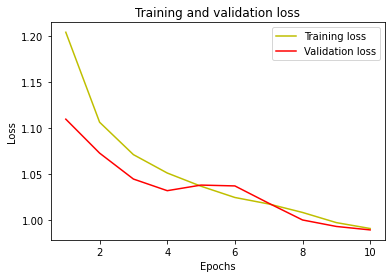

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1]:
y_pred=model.predict(image_dataset[33])
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

NameError: name 'model' is not defined

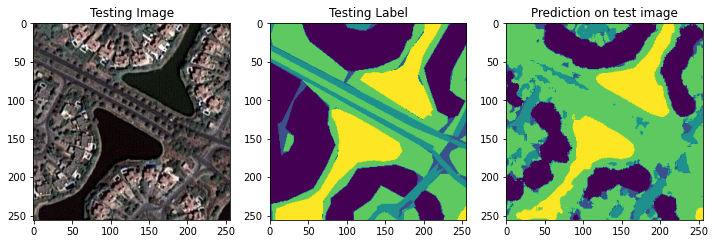

In [53]:
import random
#test_img_number = random.randint(0, len(X_test))
test_img = image_dataset[33]
ground_truth=y_test_argmax[33]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()